In [ ]:
!pip install deepinv

In [40]:
import torch
import deepinv
from torchvision import datasets, transforms

In [41]:
device = "cuda"
batch_size = 32
image_size = 32

transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.0,), (1.0,)),
    ]
)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [43]:
lr = 1e-4
epochs = 2

# u-net variant for diffusion tasks.
model = deepinv.models.DiffUNet(in_channels=1, out_channels=1, pretrained = None).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# use MSE loss to measure pixel-wise reconstruction error between output and target images
mse = torch.nn.MSELoss()

In [36]:
# noise variance schedule
beta_start = 1e-4
beta_end = 0.02
timesteps = 1000

# betas control how much noise you add at each step — starting from very little noise to more noise gradually.
betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
# alphas tell you how much of the original image is preserved each step (since it’s 1 - beta).
alphas = 1.0 - betas
# shows how much of the original image remains after multiple noising steps.
alphas_cumprod = torch.cumprod(alphas, dim=0)

# efficiency
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

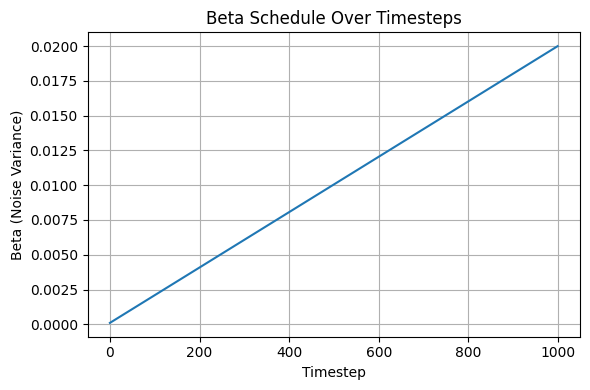

In [48]:
betas_cpu = betas.cpu().numpy()
plt.figure(figsize=(6, 4))
plt.plot(range(timesteps), betas_cpu)
plt.title("Beta Schedule Over Timesteps")
plt.xlabel("Timestep")
plt.ylabel("Beta (Noise Variance)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
from tqdm import tqdm

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    num_batches = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for data, _ in progress_bar:
        imgs = data.to(device)
        # sample random gaussian noise
        noise = torch.randn_like(imgs)
        # this tells us how many noise steps to add to each image in this batch
        t = torch.randint(0, timesteps, (imgs.size(0),), device=device)

        # forward process. add noise to the original img
        noised_imgs = (
            sqrt_alphas_cumprod[t, None, None, None] * imgs
            + sqrt_one_minus_alphas_cumprod[t, None, None, None] * noise
        )

        optimizer.zero_grad()
        # predict the noise added to the image at timestep t using the model
        estimated_noise = model(noised_imgs, t, type_t = "timestep")
        loss = mse(estimated_noise, noise)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1
        progress_bar.set_postfix({"loss": loss.item()})

    avg_loss = epoch_loss / num_batches
    print(f"[Epoch {epoch+1}/{epochs}] Avg Loss: {avg_loss:.6f}")

[Epoch 1/2] Avg Loss: 0.014597


[Epoch 2/2] Avg Loss: 0.011779


In [51]:
model.eval() # disable regularization

n_samples = 32

with torch.no_grad():
  # pure gaussian noise
  x = torch.randn(n_samples, 1, image_size, image_size).to(device)

  # reverse diffusion process
  for t in tqdm(reversed(range(timesteps)), desc="sampling"):
    # create a tensor of shape (n_samples,) filled with current timestep t
    t_tensor = torch.ones(n_samples, device=device).long() * t

    # predict the noise component at timestep t using the model
    predicted_noise = model(x, t_tensor, type_t="timestep")

    # retrieve diffusion constants at timestep t
    alpha = alphas[t]
    alpha_cumprod = alphas_cumprod[t]
    beta = betas[t]

    if t > 0:
      noise = torch.randn_like(x)
    else:
      noise = 0

    # update the image estimate x using the reverse diffusion formula:
    x = (1 / torch.sqrt(alpha)) * (
        x - (beta / torch.sqrt(1 - alpha_cumprod)) * predicted_noise
    ) + torch.sqrt(beta) * noise

sampling: 1000it [00:53, 18.75it/s]


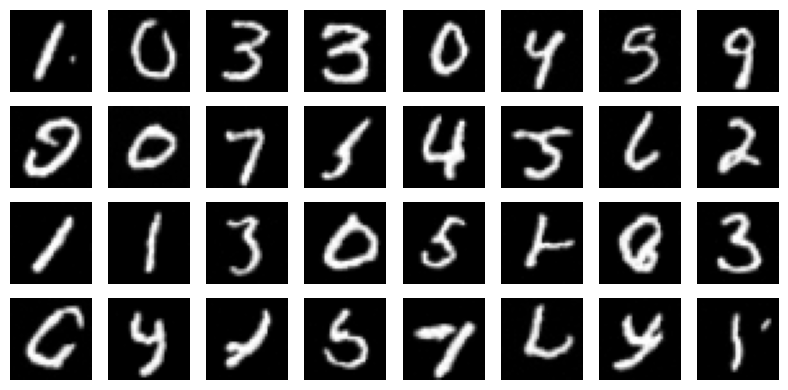

In [52]:
import matplotlib.pyplot as plt

samples = x.clamp(0.0, 1.0).cpu()

n_rows = 4
n_cols = 8
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))

for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i][0], cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()